<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais</font></b></strong>

<strong><b><font size="5">Pré processamento</font></b></strong>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

Em Estatística e Econometria, e em particular na análise de séries temporais, um **modelo de média móvel integrada auto-regressiva (ARIMA)** é uma generalização de um modelo de média móvel auto-regressiva (ARMA). 

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de **estacionariedade**, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade. 

**A parte AR do ARIMA** indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). 

**O I (para "integrado")** indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez).

**A parte MA** indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado.  

O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

Teremos algumas aulas para estudar Modelos Arima. Mas já vamos começar com nosso primeiro modelo.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Referência: Data Science Academy" --iversions

Author: Referência: Data Science Academy

sklearn    : 1.0.2
sys        : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
statsmodels: 0.13.2
numpy      : 1.21.5
pandas     : 1.4.4
matplotlib : 3.5.2



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [3]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [4]:
# Dados
dataframe.head()

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0


In [5]:
dataframe.index

DatetimeIndex(['2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29',
               '2021-10-30', '2021-10-31', '2021-11-01', '2021-11-02',
               '2021-11-03', '2021-11-04',
               ...
               '2022-10-16', '2022-10-17', '2022-10-18', '2022-10-19',
               '2022-10-20', '2022-10-21', '2022-10-22', '2022-10-23',
               '2022-10-24', '2022-10-25'],
              dtype='datetime64[ns]', name='Data', length=365, freq='D')

In [6]:
# Tipos de dados
dataframe.dtypes

Quantidade    float64
dtype: object

In [7]:
# Shape
dataframe.shape

(365, 1)

In [8]:
dataframe.describe()

,Quantidade
count,365.000000
mean,113.072603
std,69.687170
min,3.000000
25%,55.500000
50%,110.000000
75%,162.000000
max,336.000000


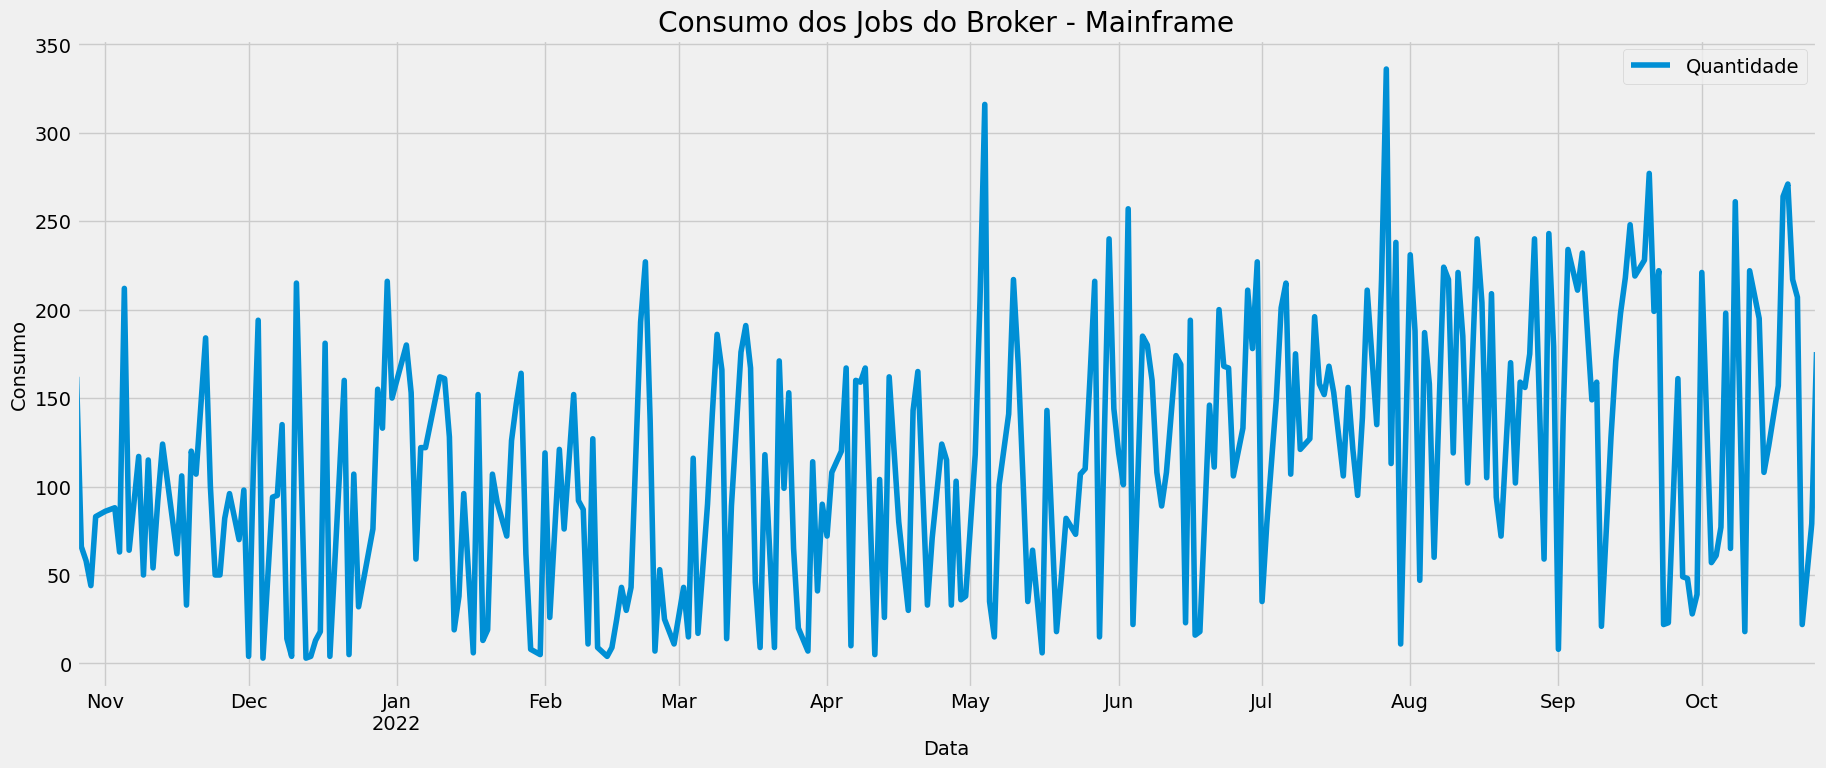

In [9]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [10]:
# Média móvel de 30 dias

rolmean = dataframe.rolling(window = 30).mean()

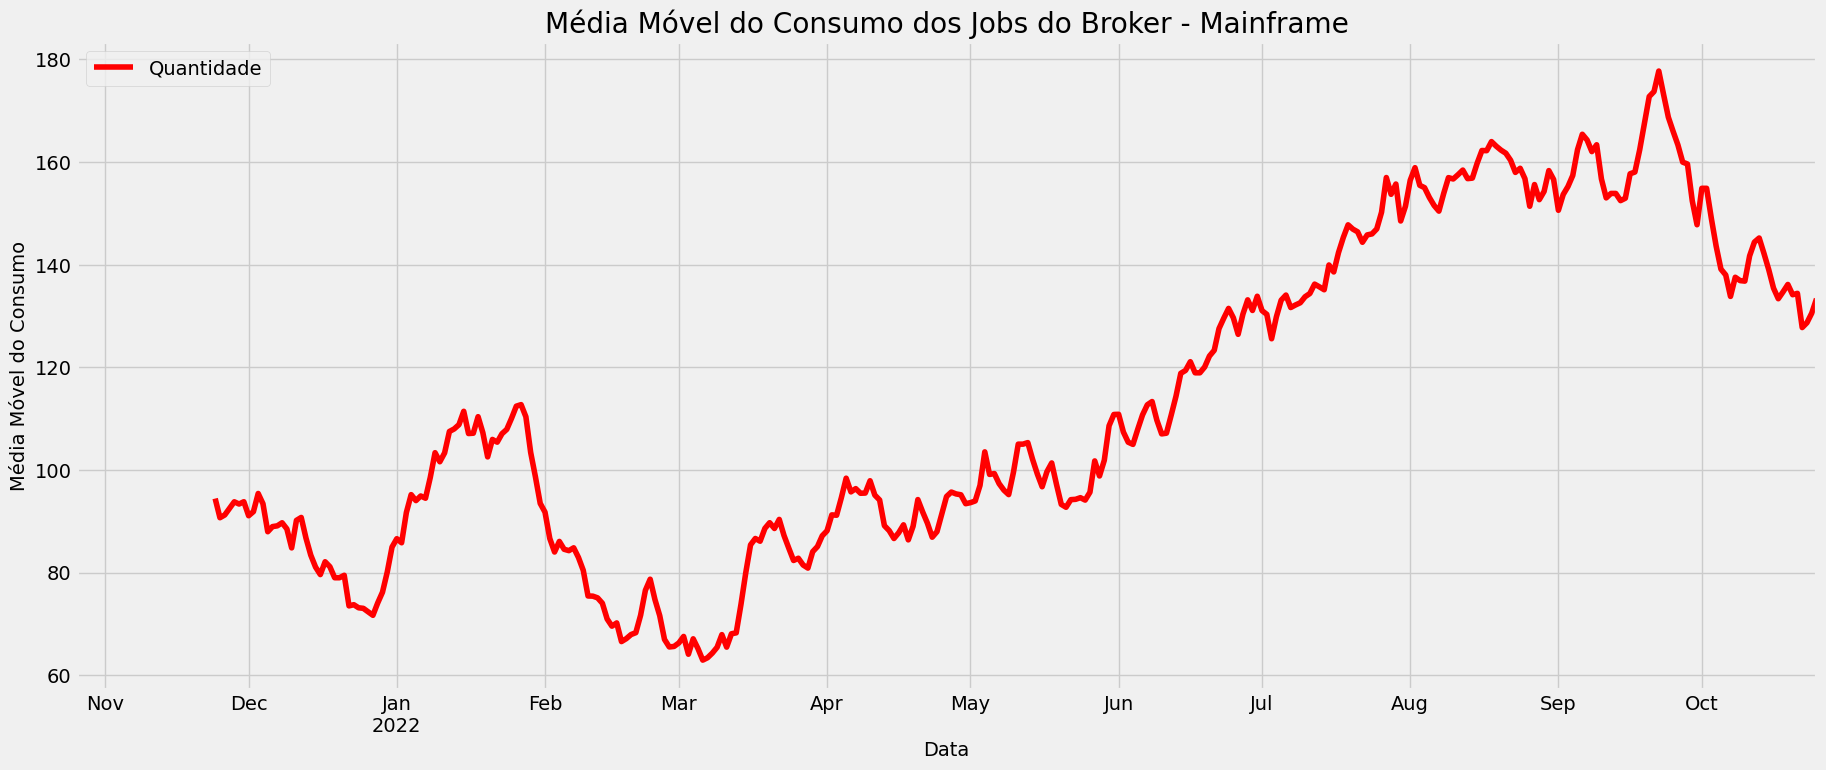

In [11]:
# Plot
rolmean.plot(title = 'Média Móvel do Consumo dos Jobs do Broker - Mainframe', fontsize = 14, 
             label = 'Consumo do Broker', color = 'red') 
plt.xlabel("Data") 
plt.ylabel("Média Móvel do Consumo") 
plt.legend(loc = 'best') 
plt.show()

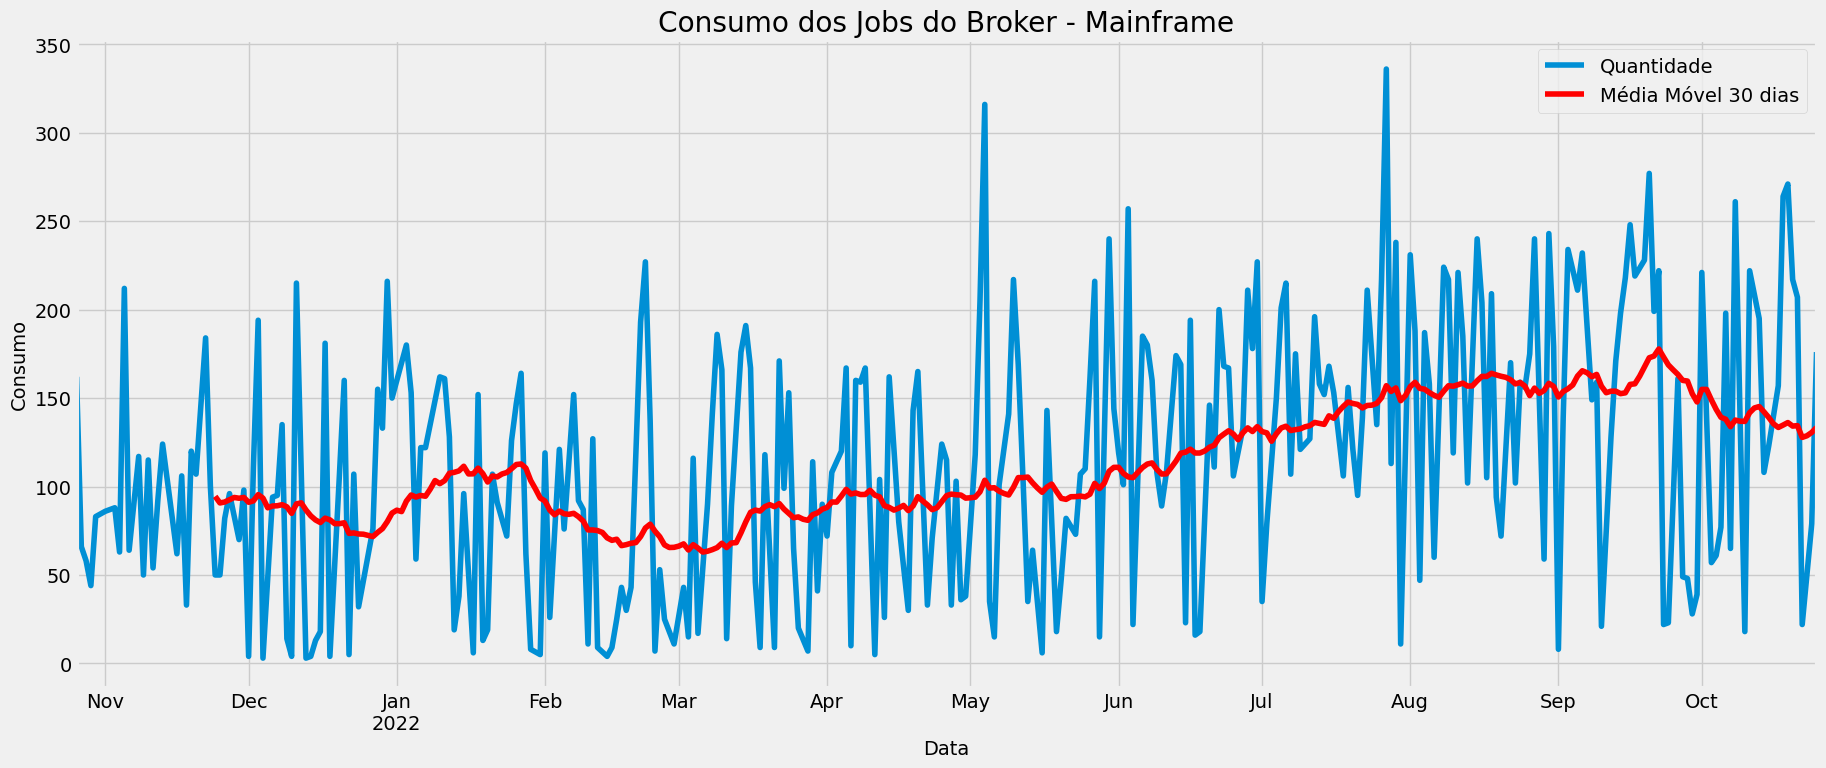

In [12]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.plot(rolmean, label = 'Média Móvel 30 dias', color = 'red')
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [13]:
# A variável Quantidade é nossa variável target 
target = dataframe['Quantidade']

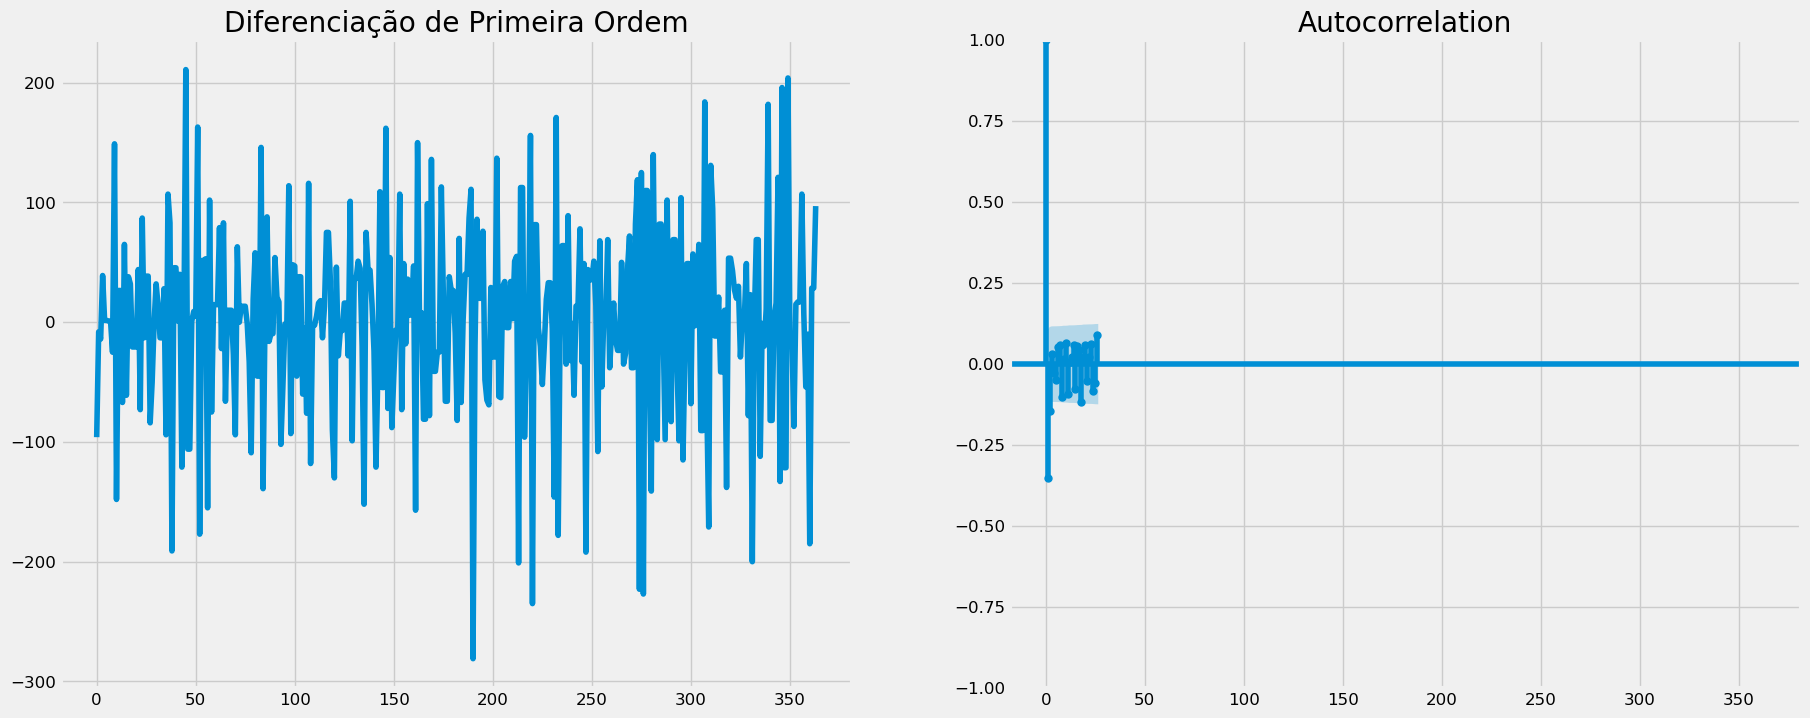

In [14]:
# Gráfico ACF
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,1.2))
plot_acf(np.diff(target.values), ax = axes[1])
plt.show()

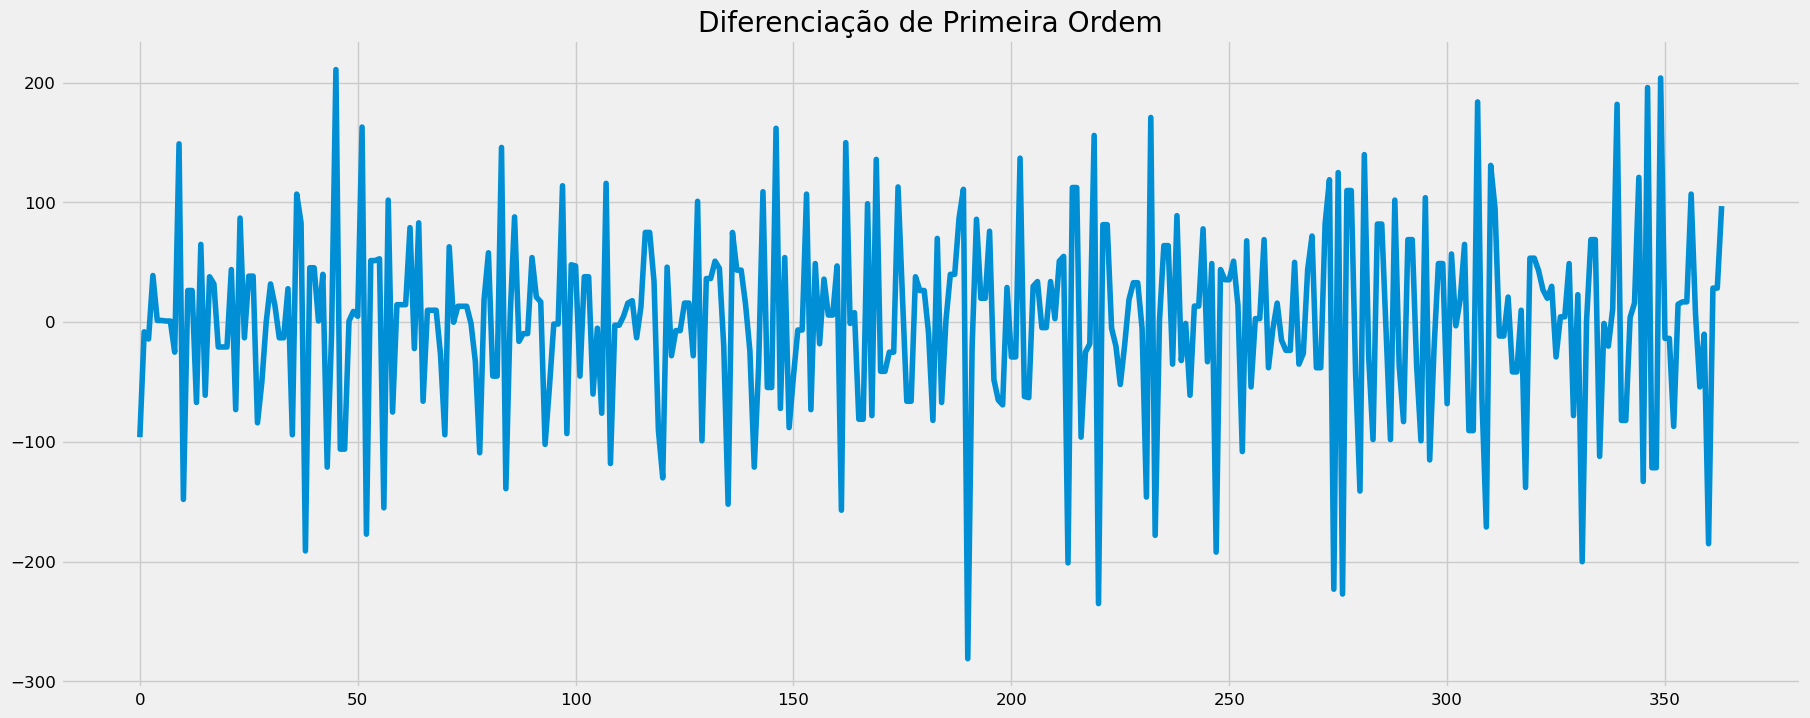

In [15]:
# Gráfico ACF
plt.plot(np.diff(target.values))
plt.title('Diferenciação de Primeira Ordem')
plt.show()

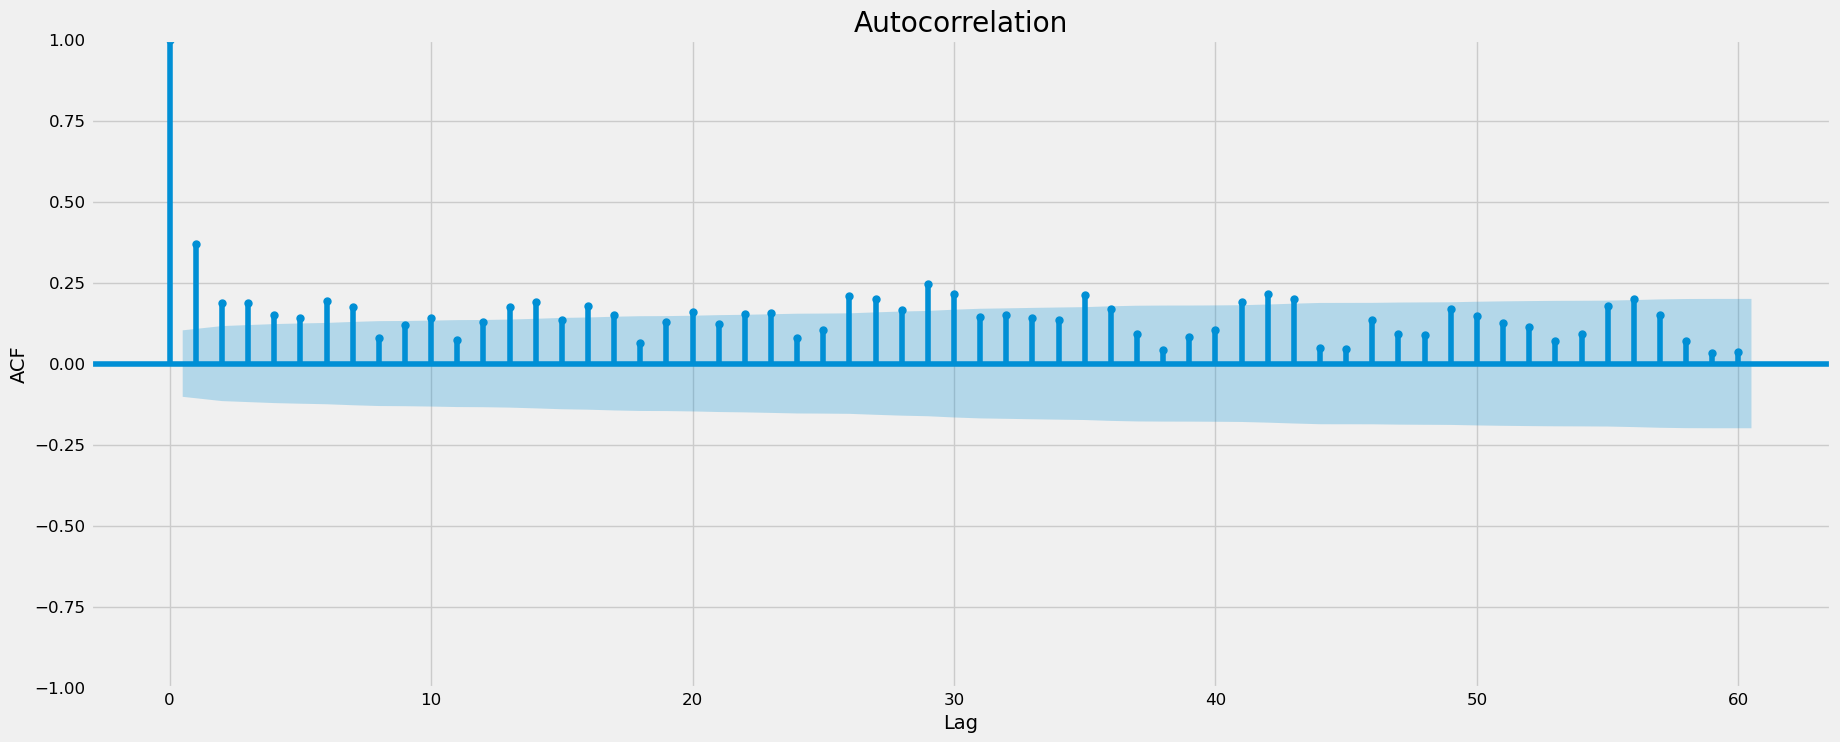

In [16]:
plot_acf(target.values,lags=60)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

**ACF medição da autocorrelação entre períodos anteriores com o período atual (lags)**

**Para haver auto correlação com a lag anterior os valores devem estar FORA da faiza azul (intervalo de confiaça)**

**Se todos os valores estiverem DENTRO da faixa azul temos o ruído branco ou passeio aleatório onde não há auto correlação**

In [18]:
import scipy.stats as stats

In [22]:
# Random seed 
np.random.seed(7)

Vamos testar a estacionaridade da série.

In [21]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 10).mean()
    rolstd = serie.rolling(window = 10).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

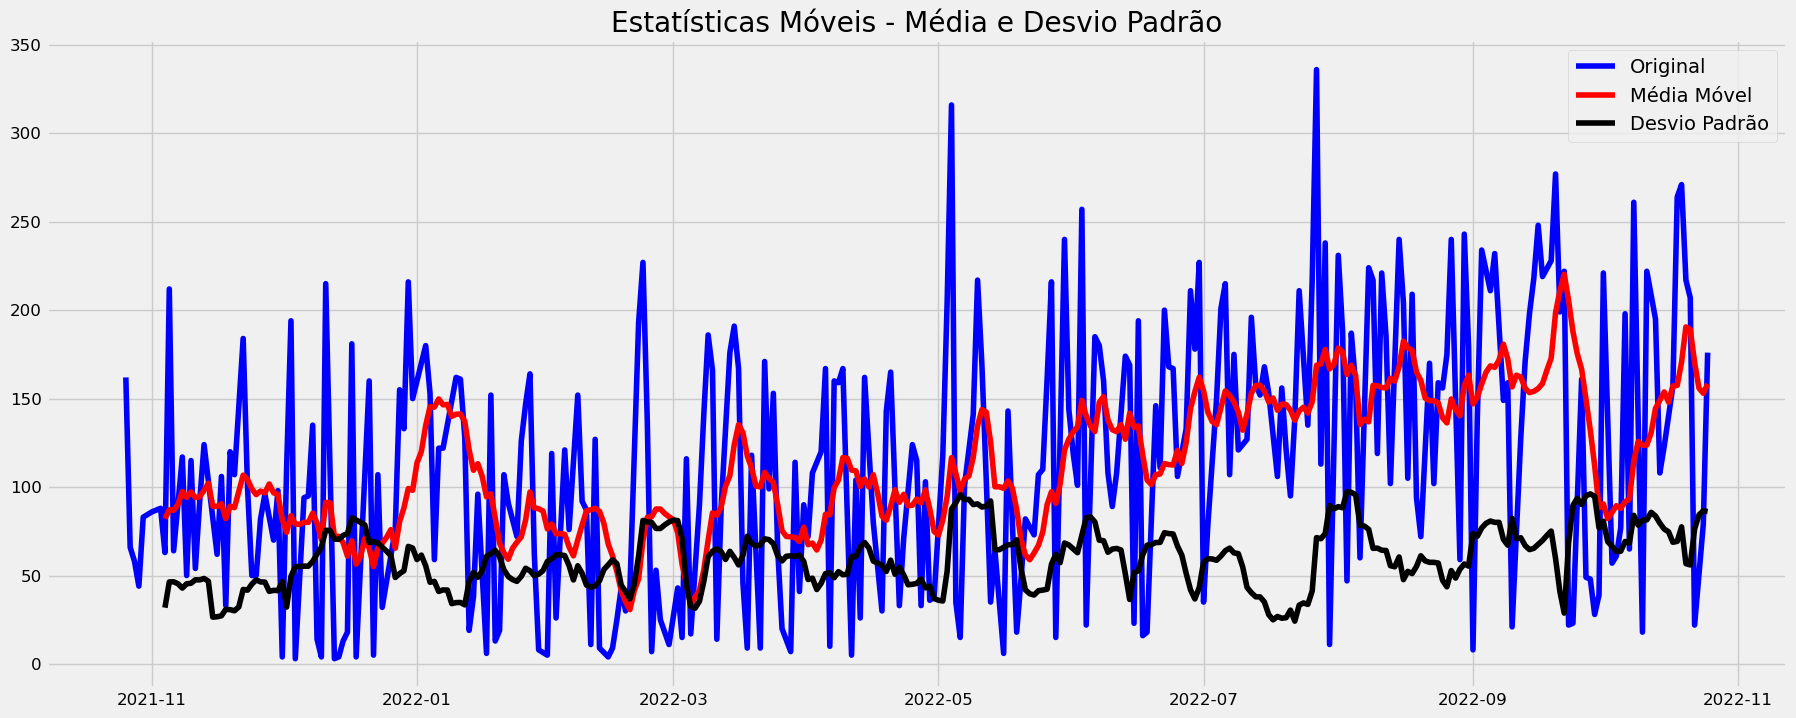


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -5.155394
Valor-p                           0.000011
Número de Lags Consideradas       5.000000
Número de Observações Usadas    359.000000
Valor Crítico (1%)               -3.448697
Valor Crítico (5%)               -2.869625
Valor Crítico (10%)              -2.571077
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [22]:
# Aplica a função 
testa_estacionaridade(dataframe['Quantidade'])

A série já é estacionária.

Vamos decompor a série e analisar seus componentes em separado.

In [23]:
# Decompondo a série temporal
decomposition = seasonal_decompose(dataframe['Quantidade'])

In [24]:
# Extraindo cada componente da série
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

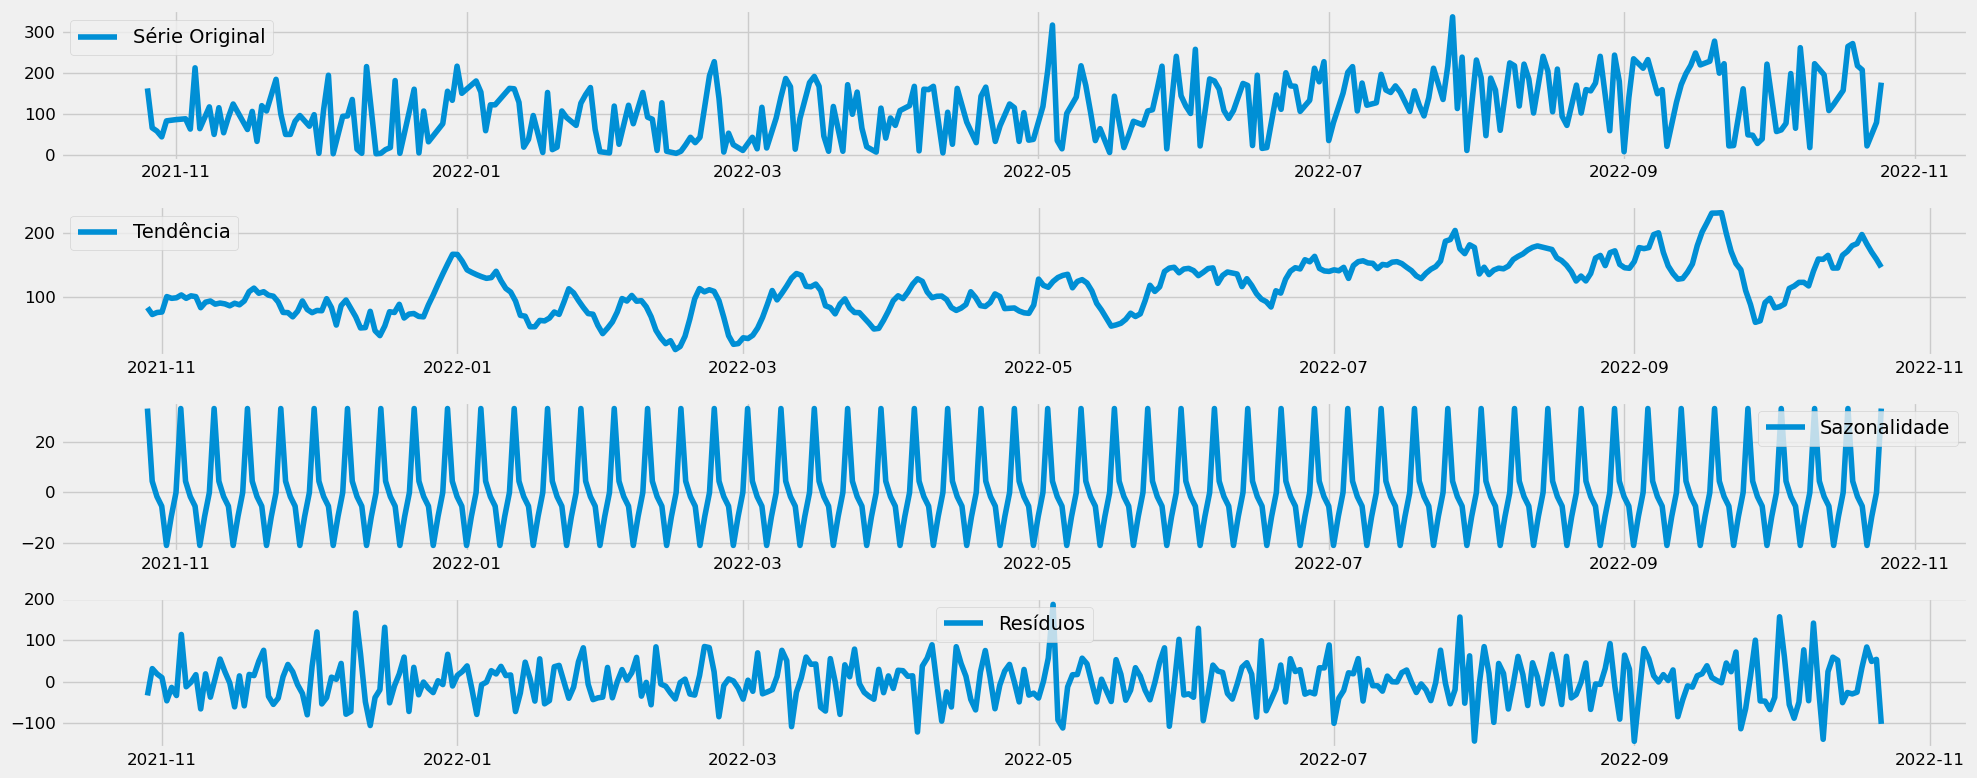

In [25]:
# Plot
plt.subplot(411)
plt.plot(dataframe['Quantidade'], label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

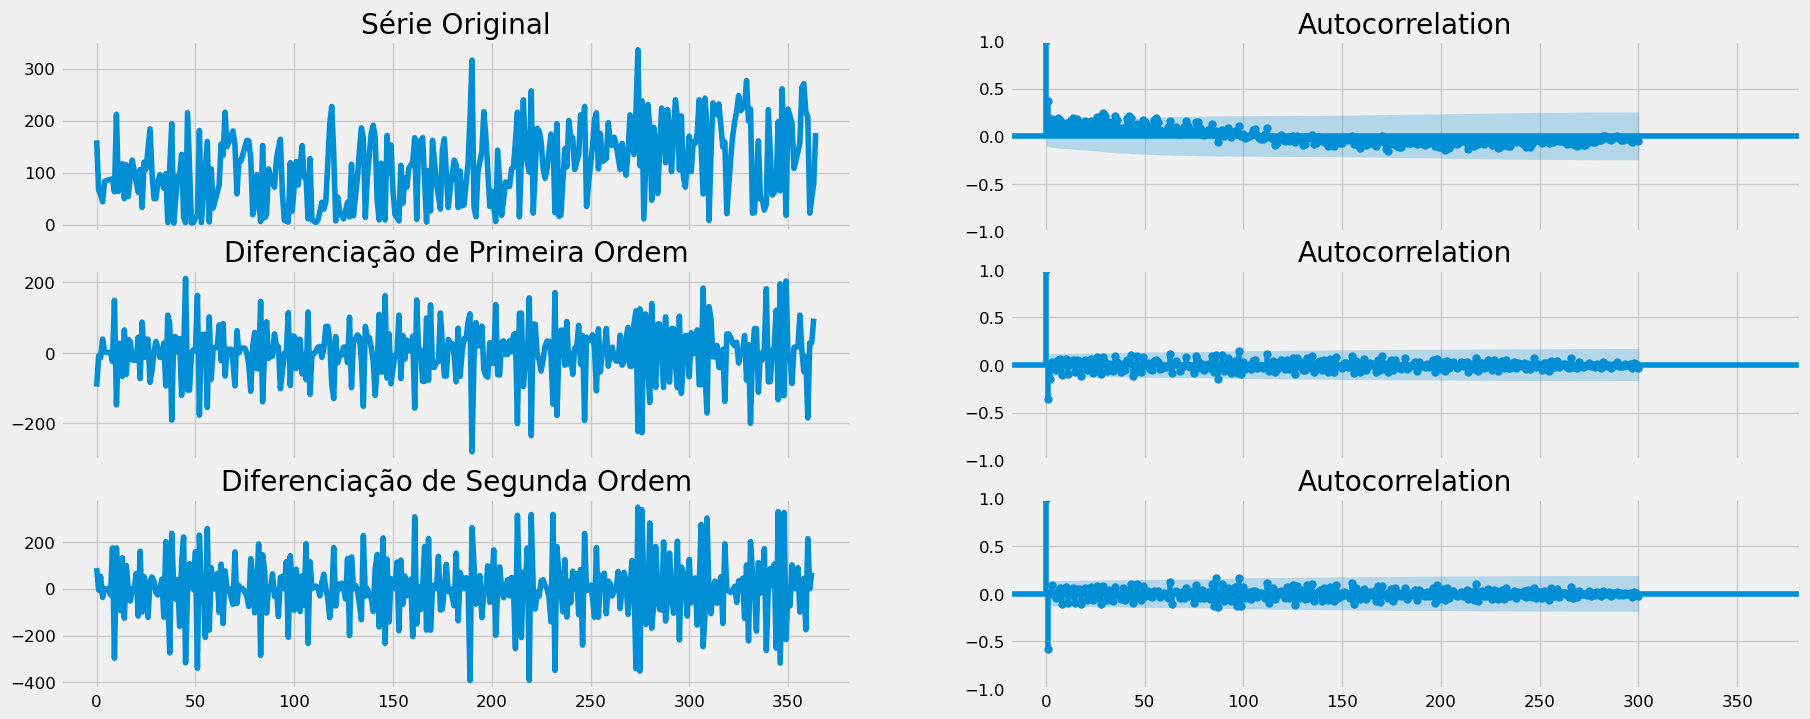

In [26]:
# Área de Plotagem
fig, axes = plt.subplots(3, 2, sharex = True)

# Série Original
axes[0, 0].plot(target.values); axes[0, 0].set_title('Série Original')
plot_acf(target.values, lags = 300, ax = axes[0, 1])

# Diferenciação de Primeira Ordem
axes[1, 0].plot(np.diff(target.values)); axes[1, 0].set_title('Diferenciação de Primeira Ordem')
plot_acf(np.diff(target.values), lags = 300, ax = axes[1, 1])

# Diferenciação de Segunda Ordem
axes[2, 0].plot(np.diff(np.diff(target.values))); axes[2, 0].set_title('Diferenciação de Segunda Ordem')
plot_acf(np.diff(np.diff(target.values)), lags = 300, ax = axes[2, 1])

plt.show()

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim